# 설정

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "model_selection"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# k-겹 교차 검증을 사용한 모델 성능 평가

머신 러닝 모델을 구축하는 핵심 단계 중 하나는 처음 본 데이터에 대한 모델 성능을 추정하는 것이다. 훈련 세트에서 모델을 학습하고 같은 데이터로 새로운 데이터에 얼마나 잘 동작하는지 추정한다고 가정해 보자. 이는 모델이 너무 간단하면 과소적합(높은 편향)이 문제가 되고 너무 복잡하면 훈련 데이터에 과대적합(높은 분산)될 수 있다. 또한 고정된 학습 데이터와 테스트 데이터로 평가를 하다 보면 테스트 데이터에만 최적의 성능을 발휘할 수 있도록 편향되게 모델을 유도하는 경향이 생기게 된다. 결국은 해당 테스트 데이터에만 과적합되는 학습 모델이 만들어져 다른 테스트 데이터가 들어올 경우에는 성능이 저하된다.

적절한 편향-분산 트레이드오프를 찾으려면 모델을 주의 깊게 평가해야 한다. 여기서는 보편적인 교차 검증 기법인 <b>홀드아웃 교차 검증</b><sup>holdout cross-validation</sup>, <b>k-겹 교차 검증</b><sup>k-fold cross-validation</sup> 그리고 추가적인 검증 기법을 배우겠다. 이런 방법들은 모델의 일반화 성능, 즉 처음 본 데이터에 모델이 얼마나 잘 동작하는지 신뢰할 만한 추정을 하도록 도와준다.

## 홀드아웃 방법

전통적이고 널리 사용되는 머신 러닝 모델의 일반화 성능 추정 방법은 홀드아웃 교차 검증이다. 홀드 아웃 방법은 초기 데이터셋을 별도의 훈련 세트와 테스트 세트로 나눈다. 전자는 모델 훈련에 사용하고 후자는 일반화 성능을 추정하는 데 사용한다. 일반적인 머신 러닝 애플리케이션에서는 처음 본 데이터에서 예측 성능을 높이기 위해 하이퍼파라미터를 튜닝하고 비교해야 한다. 이 과정을 모델 선택이라고 한다. 모델 선택이란 용어는 주어진 분류 문제에서 튜닝할 파라미터(또는 하이퍼파라미터)의 최적 값을 선택해야 하는 것을 의미한다. 모델 선택에 같은 테스트 세트를 반복해서 재사용하면 훈련 세트의 일부가 되는 셈이고 결국 모델은 과대적합될 것이다. 아직도 많은 사람이 모델 선택을 위해 테스트 세트를 사용한다. 이는 좋은 머신 러닝 작업 방식이 아니다.

모델 선택에 홀드아웃 방법을 사용하는 가장 좋은 방법은 데이터를 훈련 세트, 검증 세트, 테스트 세트 세 개의 부분으로 나누는 것이다. 훈련 세트는 여러 가지 모델을 훈련하는 데 사용한다. 검증 세트에 대한 성능은 모델 선택에 사용한다. 훈련과 모델 선택 단계에서 모델이 만나지 못한 테스트 세트를 분리했기 때문에 새로운 데이터에 대한 일반화 능력을 덜 편향되게 추정할 수 있는 장점이 있다. [그림 1]는 홀드아웃 교차 검증의 개념을 보여 준다. 검증 세트를 사용하여 반복적으로 다른 파라미터 값에서 모델을 훈련한 후 성능을 평가한다. 만족할 만한 하이퍼파라미터 값을 얻었다면 테스트 세트에서 모델의 일반화 성능을 추정한다.

<b>그림 1</b> 홀드아웃 교차 검증
<div style="text-align:center;">
    <img src="./images/model_selection/홀드아웃 교차 검증.jpg">
</div>

홀드아웃 방법은 훈련 데이터를 훈련 세트와 검증 세트로 나누는 방법에 따라 성능 추정이 민감할 수 있다는 것이 단점이다. 검증 세트의 성능 추정이 어떤 샘플을 사용하느냐에 따라 달라질 것이다.

## k-겹 교차 검증

k-겹 교차 검증에서는 중복을 허락하지 않고 훈련 데이터셋을 k개의 폴드로 랜덤하게 나눈다. k-1개의 폴드로 모델을 훈련하고 나머지 하나의 폴드로 성능을 평가한다. 이 과정을 k번 반복하여 k개의 모델과 성능 추정을 얻는다.

그다음 서로 다른 독립적인 폴드에서 얻은 성능 추정을 기반으로 모델의 평균 성능을 계산한다. 홀드아웃 방법에 비해 훈련 세트의 분할에 덜 민감한 성능 추정을 얻을 수 있다. 일반적으로 모델 튜닝에 k-겹 교차 검증을 사용한다. 즉, 만족할 만한 일반화 성능을 내는 최적의 하이퍼파라미터 값을 찾기 위해 사용한다.

만족스러운 하이퍼파라미터 값을 찾은 후에는 전체 훈련 세트를 사용하여 모델을 다시 훈련한다. 그다음 독립적인 테스트 세트를 사용하여 최종 성능 추정을 한다. k-겹 교차 검증 후에 전체 훈련 세트로 모델을 학습하는 이유는 훈련 샘플이 많을수록 학습 알고리즘이 더 정확하고 안정적인 모델을 만들기 때문이다.

k-겹 교차 검증이 중복을 허락하지 않는 리샘플링 기법이기 때문에 모든 샘플 포인트가 훈련하는 동안 (테스트 폴드로) 검증에 딱 한 번 사용되는 장점이 있다.<sup><a id="a01" href="p01">[1]</a></sup> 이로 인해 홀드아웃 방법보다 모델 성능의 추정에 분산이 낮다. [그림 2]는 k=10일 때 k-겹 교차 검증의 개념을 요약한 것이다. 훈련 데이터는 열 개의 폴드로 나누어지고 열 번의 반복 동안 아홉 개의 폴드는 훈련에, 한 개의 폴드는 모델 평가를 위해 사용된다. 각 폴드의 추정 성능 $E_i$(예를 들어 분류 정확도 또는 오차)를 사용하여 모델의 평균 성능 $E$를 계산한다.

<b>그림 2</b> k-겹 교차 검증
<div style="text-align:center;">
    <img src="./images/model_selection/k-겹 교차 검증.jpg">
</div>

경험적으로 보았을 때 k-겹 교차 검증에서 좋은 기본값은 k=10이다. 예를 들어 론 코하비<sup>Ron Kohavi</sup>는 여러 종류의 실제 데이터셋에서 수행한 실험을 통해 10-겹 교차 검증이 가장 뛰어난 편향-분산 트레이드오프를 가진다고 제안했다.<sup><a id="a02" href="#p02">[2]</a></sup>

비교적 작은 훈련 세트로 작업한다면 폴드 개수를 늘리는 것이 좋다. k 값이 증가하면 더 많은 훈련 데이터가 각 반복에 사용되고 모델 성능을 평균하여 일반화 성능을 추정할 때 더 낮은 편향을 만든다. k 값이 아주 크면 교차 검증 알고리즘의 실행 시간이 늘어나고 분산이 높은 추정을 만든다. 이는 훈련 폴드가 서로 많이 비슷해지기 때문이다. 다른 말로 하면 대규모 데이터셋으로 작업할 때는 k=5와 같은 작은 k 값을 선택해도 모델의 평균 성능을 정확하게 추정할 수 있다. 또 폴드마다 모델을 학습하고 평가하는 계산 비용을 줄일 수 있다.

<div style="background-color:#D3D3D3; padding:10px;">
    <span style="color: #D0B134"><strong>NOTEΞ</strong></span> k-겹 교차 검증의 특별한 경우는 LOOCV(Leave-One-Out Cross-Validation) 방법이다. LOOCV에서는 폴드 개수가 훈련 샘플 개수와 같다(k = n). 즉, 하나의 훈련 샘플이 각 반복에서 테스트로 사용된다. 이 방법은 자주 작은 데이터셋을 사용할 때 권장된다.<sup><a id="a03" href="#p03">[3]</a></sup>

사이킷런에서는 k-겹 교차 검증 프로세스를 구현하기 위해 KFold 클래스를 제공한다. KFold 클래스를 이용해 붓꽃 데이터셋을 교차 검증하고 예측 정확도를 알아보겠다. 붓꽃 데이터 세트와 DecisionTreeClassifier를 생성하고 5개의 폴드 세트로 분리하는 KFold 객체를 생성한다.

In [2]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import numpy as np

iris = load_iris()
features = iris.data
label = iris.target
df_clf = DecisionTreeClassifier(random_state=156)

# 5개의 폴드 세트로 분리하는 KFold 객체와 폴드 세트별 정확도를 담을 리스트 객체 생성.
kfold = KFold(n_splits=5)
cv_accuracy = []
print('붓꽃 데이터 세트 크기:', features.shape[0])

붓꽃 데이터 세트 크기: 150


<code>KFold(n_splits=5)</code>로 KFold 객체를 생성했으니 이제 생성된 KFold 객체의 <code>split()</code>을 호출해 전체 붓꽃 데이터를 5개의 폴드 데이터 세트로 분리한다. 전체 데이터는 모두 150개다. 따라서 학습용 데이터 세트는 이 중 4/5인 120개, 검증 테스트 데이터 세트는 1/5인 30개로 분할된다. KFold 객체는 <code>split()</code>을 호출하면 학습용/검증용 데이터로 분할할 수 있는 인덱스를 반환한다. 실제로 학습용/검증용 데이터 추출은 반환된 인덱스를 기반으로 개발 코드에서 직접 수행해야 한다. 다음 예제는 5개의 폴드 세트를 생성하는 KFold 객체의 <code>split()</code>을 호출해 교차 검증 수행 시마다 학습과 검증을 반복해 예측 정확도를 측정한다. 그리고 <code>split()</code>이 어떤 값을 실제로 반환하는지도 확인해 보기 위해 검증 데이터 세트의 인덱스도 추출해 보겠다.

In [3]:
# KFold 객체의 split()를 호출하면 폴드 별 학습용, 검증용 테스트의 로우 인덱스를 array로 반환
for k, (train_index, val_index) in enumerate(kfold.split(features)):
    # kfold.split()으로 반환된 인덱스를 이용해 학습용, 검증용 테스트 데이터 추출
    X_train, X_test = features[train_index], features[val_index]
    y_train, y_test = label[train_index], label[val_index]
    # 학습 및 예측
    df_clf.fit(X_train, y_train)
    pred = df_clf.predict(X_test)
    # 반복 시마다 정확도 측정
    accuracy = np.round(accuracy_score(y_test, pred), 4)
    train_size = X_train.shape[0]
    test_size = X_test.shape[0]
    print('\n{0}Fold 교차 검증 정확도: {1}, 학습 데이터 크기: {2}, 검증 데이터 크기: {3}'
          .format(k+1, accuracy, train_size, test_size))
    print('{0}Fold 검증 세트 인덱스:{1}'.format(k+1, val_index))
    cv_accuracy.append(accuracy)
    
# 개별 iteration별 정확도를 합하여 평균 정확도 계산
print('\nCV 정확도: %.3f +/- %.3f' %
      (np.mean(cv_accuracy), np.std(cv_accuracy)))


1Fold 교차 검증 정확도: 1.0, 학습 데이터 크기: 120, 검증 데이터 크기: 30
1Fold 검증 세트 인덱스:[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

2Fold 교차 검증 정확도: 0.9667, 학습 데이터 크기: 120, 검증 데이터 크기: 30
2Fold 검증 세트 인덱스:[30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59]

3Fold 교차 검증 정확도: 0.8667, 학습 데이터 크기: 120, 검증 데이터 크기: 30
3Fold 검증 세트 인덱스:[60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83
 84 85 86 87 88 89]

4Fold 교차 검증 정확도: 0.9333, 학습 데이터 크기: 120, 검증 데이터 크기: 30
4Fold 검증 세트 인덱스:[ 90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119]

5Fold 교차 검증 정확도: 0.7333, 학습 데이터 크기: 120, 검증 데이터 크기: 30
5Fold 검증 세트 인덱스:[120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
 138 139 140 141 142 143 144 145 146 147 148 149]

CV 정확도: 0.900 +/- 0.094


5겹 교차 검증 결과 평균 검증 정확도는 0.9다. 그리고 교차 검증 시마다 검증 세트의 인덱스가 달라짐을 알 수 있다. 검증 세트의 인덱스를 보면 교차 검증 시마다 <code>split()</code> 함수가 어떻게 인덱스를 할당하는지 알 수 있다. 첫 번째 교차 검증에서는 0번 ~ 29번, 두 번째는 30번 ~ 59번, 세 번째는 60번 ~ 89번, 네 번째는 90번 ~ 119번, 다섯 번째는 120 ~ 149번으로 각각 30개의 검증 세트 인덱스를 생성했고, 이를 기반으로 검증 세트를 추출하게 된다.

## Stratified K 폴드

Stratified K 폴드는 불균형한<sup>imbalanced</sup> 분포도를 가진 레이블(결정 클래스) 데이터 집합을 위한 K 폴드 방식이다. 불균형한 분포도를 가진 레이블 데이터 집합은 특정 레이블 값이 특이하게 많거나 매우 적어서 값의 분포가 한쪽으로 치우치는 것을 말한다.

특정 레이블 값이 특이하게 많거나 매우 적어서 값의 분포가 한쪽으로 치우쳐진 불균형한 분포도를 가진 데이터 집합에는 Stratified K 폴드가 더 적절하다. 이는 좀 더 나은 편향과 분산 추정을 만든다. 특히 론 코하비가 보인 것처럼 클래스 비율이 동등하지 않을 때다.<sup><a id="a04" href="#p04">[4]</a></sup> 계층적 교차 검증은 각 폴드에서 클래스 비율이 전체 훈련 세트에 있는 클래스 비율을 대표하도록 유지한다.

가령 대출 사기 데이터를 예측한다고 가정해 보겠다. 이 데이터 세트는 1억 건이고, 수십 개의 피처와 대출 사기 여부를 뜻하는 레이블(대출 사기: 1, 정상 대출: 0)로 구성돼 있다. 그런데 대부분의 데이터는 정상 대출일 것이다. 그리고 대출 사기가 약 1,000건이 있다고 한다면 전체의 0.0001%의 아주 작은 확률로 대출 사기 레이블이 존재한다. 이렇게 작은 비율로 1 레이블 값이 있다면 K 폴드로 랜덤하게 학습 및 테스트 세트의 인덱스를 고르더라도 레이블 값인 0과 1의 비율로 제대로 반영하지 못하는 경우가 쉽게 발생한다. 즉, 레이블 값으로 1이 특정 개별 반복별 학습/테스트 데이터 세트에는 상대적으로 많이 들어 있고, 다른 반복 학습/테스트 데이터 세트에는 그렇지 못한 결과가 발생한다. 대출 사기 레이블이 1인 레코드는 비록 건수는 작지만 알고리즘이 대출 사기를 예측하기 위한 중요한 피처 값을 가지고 있기 때문에 매우 중요한 데이터 세트다. 따라서 원본 데이터와 유사한 대출 사기 레이블 값의 분포를 학습/테스트 세트에도 유지하는 게 매우 중요하다.

Stratified K 폴드는 이처럼 K 폴드가 레이블 데이터 집합이 원본 데이터 집합의 레이블 분포를 학습 및 테스트 세트에 제대로 분배하지 못하는 경우의 문제를 해결해 준다. 이를 위해 Stratified K 폴드는 원본 데이터의 레이블 분포를 먼저 고려한 뒤 이 분포와 동일하게 학습과 검증 데이터 세트를 분배한다. 먼저 K 폴드가 어떤 문제를 가지고 있는지 확인해 보고 이를 사이킷런의 StratifiedKFold 클래스를 이용해 개선해 보겠다. 이를 위해 붓꽃 데이터 세트를 간단하게 DataFrame으로 생성하고 레이블 값의 분포도를 확인한다.

In [4]:
import pandas as pd

iris = load_iris()
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df['label'] = iris.target
iris_df['label'].value_counts()

0    50
1    50
2    50
Name: label, dtype: int64

레이블 값은 0, 1, 2 값 모두 50개로 동일하다. 즉 Setosa 품종, Versicolor 품종, Virginica 품종 모두가 50개다. 이슈가 발생하는 현상을 도출하기 위해 3개의 폴드 세트를 KFold로 생성하고, 각 교차 검증 시마다 생성되는 학습/검증 레이블 데이터 값의 분포도를 확인해 보겠다.

In [5]:
kfold = KFold(n_splits=3)

for k, (train_index, val_index) in enumerate(kfold.split(iris_df)):
    label_train = iris_df['label'].iloc[train_index]
    label_test = iris_df['label'].iloc[val_index]
    print('## 교차 검증: {0}'.format(k+1))
    print('학습 레이블 데이터 분포:\n', label_train.value_counts())
    print('검증 레이블 데이터 분포:\n', label_test.value_counts())

## 교차 검증: 1
학습 레이블 데이터 분포:
 1    50
2    50
Name: label, dtype: int64
검증 레이블 데이터 분포:
 0    50
Name: label, dtype: int64
## 교차 검증: 2
학습 레이블 데이터 분포:
 0    50
2    50
Name: label, dtype: int64
검증 레이블 데이터 분포:
 1    50
Name: label, dtype: int64
## 교차 검증: 3
학습 레이블 데이터 분포:
 0    50
1    50
Name: label, dtype: int64
검증 레이블 데이터 분포:
 2    50
Name: label, dtype: int64


교차 검증 시마다 3개의 폴드 세트로 만들어지는 학습 레이블과 검증 레이블이 완전히 다른 값으로 추출되었다. 예를 들어 첫 번째 교차 검증에서는 학습 레이블의 1, 2 값이 각각 50개가 추출되었고, 검증 레이블의 0값이 50개 추출되었다. 학습 레이블은 1, 2밖에 없으므로 0의 경우는 전혀 학습하지 못한다. 반대로 검증 레이블은 0밖에 없으므로 학습 모델은 절대 0을 예측하지 못한다. 이런 유형으로 교차 검증 데이터 세트를 분할하면 검증 예측 정확도는 0이 될 수밖에 없다.

StratifiedKFold는 이렇게 KFold로 분할된 레이블 데이터 세트가 전체 레이블 값의 분포도를 반영하지 못하는 문제를 해결해 준다. 이번에는 동일한 데이터 분할을 StratifiedKFold로 수행하고 학습/검증 레이블 데이터의 분포도를 확인해 보겠다. StratifiedKFold를 사용하는 방법은 KFold를 사용하는 방법과 거의 비슷하다. 단 하나 큰 차이는 StratifiedKFold는 레이블 데이터 분포도에 따라 학습/검증 데이터를 나누기 때문에 <code>split()</code> 메서드에 인자로 피처 데이터 세트뿐만 아니라 레이블 데이터 세트도 반드시 필요하다는 사실이다(K 폴드의 경우 레이블 데이터 세트는 <code>split()</code> 메서드의 인자로 입력하지 않아도 무방하다). 폴드 세트는 3개로 설정하겠다.

In [6]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=3)

for k, (train_index, val_index) in enumerate(skf.split(iris_df, iris_df['label'])):
    label_train = iris_df['label'].iloc[train_index]
    label_test = iris_df['label'].iloc[val_index]
    print('## 교차 검증: {0}'.format(k+1))
    print('학습 레이블 데이터 분포:\n', label_train.value_counts())
    print('검증 레이블 데이터 분포:\n', label_test.value_counts())

## 교차 검증: 1
학습 레이블 데이터 분포:
 2    34
0    33
1    33
Name: label, dtype: int64
검증 레이블 데이터 분포:
 0    17
1    17
2    16
Name: label, dtype: int64
## 교차 검증: 2
학습 레이블 데이터 분포:
 1    34
0    33
2    33
Name: label, dtype: int64
검증 레이블 데이터 분포:
 0    17
2    17
1    16
Name: label, dtype: int64
## 교차 검증: 3
학습 레이블 데이터 분포:
 0    34
1    33
2    33
Name: label, dtype: int64
검증 레이블 데이터 분포:
 1    17
2    17
0    16
Name: label, dtype: int64


출력 결과를 보면 학습 레이블과 검증 레이블 데이터 값의 분포도가 동일하게 할당됐음을 알 수 있다. 교차 검증에서 학습 레이블과 검증 레이블이 레이블별로 동일하게 할당됐다. 이렇게 분할이 되어야 레이블 값 0, 1, 2를 모두 학습할 수 있고, 이에 기반해 검증을 수행할 수 있다. StratifiedKFold를 이용해 붓꽃 데이터를 교차 검증해 보겠다.

다음 코드는 StratifiedKFold를 이용해 데이터를 분리한 것이다. 피처 데이터와 레이블 데이터는 앞의 붓꽃 StratifiedKFold 예제에서 추출한 데이터를 그대로 이용하겠다.

In [7]:
dt_clf = DecisionTreeClassifier(random_state=156)

skfold = StratifiedKFold(n_splits=3)
cv_accuracy = []

# StratifiedKFold의 split() 호출 시 반드시 레이블 데이터 세트도 추가 입력 필요
for k, (train_index, test_index) in enumerate(skfold.split(features, label)):
    # split()으로 반환된 인덱스를 이용해 학습용, 검증용 테스트 데이터 추출
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = label[train_index], label[test_index]
    # 학습 및 예측
    df_clf.fit(X_train, y_train)
    pred = df_clf.predict(X_test)
    
    # 반복 시마다 정확도 측정
    accuracy = np.round(accuracy_score(y_test, pred), 4)
    train_size = X_train.shape[0]
    test_size = X_test.shape[0]
    print('\n{0}Fold 교차 검증 정확도: {1}, 학습 데이터 크기: {2}, 검증 데이터 크기: {3}'
          .format(k+1, accuracy, train_size, test_size))
    print('{0}Fold 검증 세트 인덱스:{1}'.format(k+1, val_index))
    cv_accuracy.append(accuracy)
    
# 교차 검증별 정확도 및 평균 정확도 계산
print('\n## 교차 검증별 정확도:', np.round(cv_accuracy, 4))
print('## CV 정확도: %.3f +/- %.3f' %
      (np.mean(cv_accuracy), np.std(cv_accuracy)))


1Fold 교차 검증 정확도: 0.98, 학습 데이터 크기: 100, 검증 데이터 크기: 50
1Fold 검증 세트 인덱스:[ 34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  83  84
  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 148 149]

2Fold 교차 검증 정확도: 0.94, 학습 데이터 크기: 100, 검증 데이터 크기: 50
2Fold 검증 세트 인덱스:[ 34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  83  84
  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 148 149]

3Fold 교차 검증 정확도: 0.98, 학습 데이터 크기: 100, 검증 데이터 크기: 50
3Fold 검증 세트 인덱스:[ 34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  83  84
  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 148 149]

## 교차 검증별 정확도: [0.98 0.94 0.98]
## CV 정확도: 0.967 +/- 0.019


3개의 Stratified K 폴드로 교차 검증한 결과 평균 정확도가 약 96.7%로 측정됐다. Stratified K 폴드의 경우 원본 데이터의 레이블 분포도 특성을 반영한 학습 및 검증 데이터 세트를 만들 수 있으므로 왜곡된 레이블 데이터 세트에서는 반드시 Stratified K 폴드를 이용해 교차 검증해야 한다. 사실, 일반적으로 분류에서의 교차 검증은 K 폴드가 아니라 Stratified K 폴드로 분할돼야 한다. 회귀에서는 Stratified K 폴드가 지원되지 않는다. 회귀의 결정값은 이산값 형태의 레이블이 아니라 연속된 숫자값이기 때문에 결정값별로 분포를 정하는 의미가 없기 때문이다. 다음으로 이러한 교차 검증을 보다 간편하게 제공해주는 사이킷런의 API를 살펴보겠다.

## 교차 검증을 보다 간편하게 - cross_val_score

사이킷런은 교차 검증을 좀 더 편리하게 수행할 수 있게 해주는 API를 제공한다. 대표적인 것이 <code>cross_val_score()</code>다. KFold로 데이터를 학습하고 예측하는 코드를 보면 먼저 ① 폴드 세트를 설정하고 ② for 루프에서 반복으로 학습 및 테스트 데이터의 인덱스를 추출한 뒤 ③ 반복적으로 학습과 예측을 수행하고 예측 성능을 반환했다.

<code>cross_val_score()</code>는 이런 일련의 과정을 한꺼번에 수행해주는 API다. 다음은 <code>cross_val_score()</code> API의 선언 형태다.

<code>cross_val_score(estimator, X, y=None, scoring=None, cv=None, n_jobs=1, verbose=0, fit_params=None, pre_dispatch='2*n_jobs')</code>. 이 중 estimator, X, y, cv가 주요 파라미터다.

estimator는 사이킷런의 분류 알고리즘 클래스인 Classifier 또는 회귀 알고리즘 클래스인 Regressor를 의미하고, X는 피처 데이터 세트, y는 레이블 데이터 세트, scoring은 예측 성능 평가 지표를 기술하며, cv는 교차 검증 폴드 수를 의미한다. <code>cross_val_score()</code> 수행 후 반환 값은 scoring 파라미터로 지정된 성능 지표 측정값을 배열 형태로 반환한다. <code>cross_val_score()</code>는 classifier가 입력되면 Stratified K 폴드 방식으로 레이블값의 분포에 따라 학습/테스트 세트를 분할한다(회귀의 경우는 Stratified K 폴드 방식으로 분할할 수 없으므로 K 폴드 방식으로 분할한다).

다음 코드에서 <code>cross_val_score()</code>의 자세한 사용법을 살펴보겠다. 교차 검증 폴드 수는 3, 성능 평가 지표는 정확도인 accuracy로 하겠다.

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris

iris_data = load_iris()
dt_clf = DecisionTreeClassifier(random_state=156)

data = iris_data.data
label = iris_data.target

# 성능 지표는 정확도(accuracy_score), 교차 검증 세트는 3개
scores = cross_val_score(dt_clf, data, label, scoring='accuracy', cv=3, n_jobs=1)
print('교차 검증별 정확도: ', np.round(scores, 4))
print('CV 평균 정확도: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

교차 검증별 정확도:  [0.98 0.94 0.98]
CV 평균 정확도: 0.967 +/- 0.019


<code>cross_val_score()</code>는 cv로 지정된 횟수만큼 scoring 파라미터로 지정된 평가 지표로 평가 결괏값을 배열로 반환한다. 그리고 일반적으로 이를 평균해 평가 수치로 사용한다. <code>cross_val_score()</code> API는 내부적으로 Estimator를 학습(fit), 예측(predict), 평가(evaluation)시켜주므로 간단하게 교차 검증을 수행할 수 있다. 붓꽃 데이터의 <code>cross_val_score()</code> 수행 결과와 앞 예제의 붓꽃 데이터 StratifiedKFold의 수행 결과를 비교해 보면 각 교차 검증별 정확도와 평균 정확도가 모두 동일함을 알 수 잇다. 이는 <code>cross_val_score()</code>가 내부적으로 StratifiedKFold를 이용하기 때문이다.

<code>cross_val_score()</code> 함수가 검증에 사용하는 기본 측정 지표는 회귀일 때는 $R^2$, 분류일 때는 정확도다. scoring 매개변수를 사용하여 다른 지표로 바꿀 수 있다. 사이킷런 0.19 버전에서는 교차 검증에 여러 측정 지표를 사용할 수 있는 <code>cross_validate()</code> 함수가 추가되었다. 이 함수는 각 폴드에서 훈련과 테스트에 걸린 시간을 반환하고 scoring 매개변수에 지정한 평가 지표마다 훈련 점수와 테스트 점수를 반환한다. 반환된 딕셔너리에서 훈련 점수와 테스트 점수를 추출하려면 'train_XXXX', 'test_XXXX' 형식의 키를 사용하면 된다. 앞 코드는 다음과 같이 바꾸어 쓸 수 있다.

In [9]:
from sklearn.model_selection import cross_validate

scores = cross_validate(dt_clf, data, label, scoring=['accuracy'], cv=3, 
                        return_train_score=False, n_jobs=-1)
print('CV 정확도 점수: %s' % scores['test_accuracy'])
print('CV 평균 정확도: %.3f +/- %.3f' % (np.mean(scores['test_accuracy']), np.std(scores['test_accuracy'])))

CV 정확도 점수: [0.98 0.94 0.98]
CV 평균 정확도: 0.967 +/- 0.019


<code>cross_val_score()</code> 함수의 아주 유용한 기능은 각 폴드의 평가를 컴퓨터에 있는 복수 개의 CPU 코어에 분산할 수 있다는 점이다. n_jobs 매개변수를 1로 설정하면 하나의 CPU 코어만 성능 평가에 사용한다. n_jobs=2로 설정하면 두 개의 CPU 코어에 교차 검증을 10회씩 분산할 수 있다. n_jobs=-1로 설정하면 컴퓨터에 설치된 모든 CPU 코어를 사용하여 병렬 처리한다.

## 교차 검증 상세 옵션

앞서 <code>cross_val_score()</code>를 사용할 때 cv 매개변수를 이용해 폴드의 개수를 조정했다. 그러나 사이킷런에서는 cv 매개변수에 <b>교차 검증 분할기</b><sup>cross-validation splitter</sup>를 전달함으로써 데이터를 분할할 때 더 세밀하게 제어할 수 있다. 대부분의 경우 회귀에서는 k-겹 교차 검증, 분류에서는 계층별 k-겹 교차 검증의 기본값이 잘 작동한다. 하지만 조금 다른 전략이 필요할 때가 있다. 예를 들면, 다른 사람의 결과를 재현하기 위해 분류 데이터셋에 기본 k-겹 교차 검증을 사용해야 할 때다. 이렇게 하려면 먼저 model_selection 모듈에서 KFold 분할기를 임포트하고 원하는 폴드 수를 넣어 객체를 생성해야 한다.

In [10]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5)

그런 다음 kfold 객체를 <code>cross_val_score()</code>의 cv 매개변수로 전달한다.

In [13]:
from sklearn.linear_model import LogisticRegression
print("교차 검증 점수:\n", cross_val_score(LogisticRegression(max_iter=1000), data, label,
                                           cv=kfold))

교차 검증 점수:
 [1.         1.         0.86666667 0.93333333 0.83333333]


다음 iris 데이터셋에 (기본) 3-겹 교차 검증을 사용하는 것이 좋은 방법이 아님을 확인해보겠다.

In [14]:
kfold = KFold(n_splits=3)
print("교차 검증 점수:\n", cross_val_score(LogisticRegression(max_iter=1000), data, label,
                                           cv=kfold))

교차 검증 점수:
 [0. 0. 0.]


이는 앞서 <code>KFold.split()</code>를 통해 얻은 데이터셋으로 학습한 것과 동일한 결과를 가져온다. 역시 각 폴드는 iris 데이터셋의 클래스 중 하나에 대응하므로 아무것도 학습할 수가 없다. 계층별 폴드를 만드는 대신 이 문제를 해결하는 다른 방법은 데이터를 섞어서 샘플의 순서를 뒤죽박죽으로 만드는 것이다. 이렇게 하려면 KFold의 shuffle 매개변수를 True로 주면 된다. 데이터를 섞을 때 random_state를 고정해서 똑같은 작업을 재현할 수 있다. 그렇지 않으면 <code>cross_val_score()</code>를 실행할 때마다 폴드가 바뀌어 매번 결과가 달라질 것이다. 데이터를 분할하기 전에 섞어주면 결과를 더 좋게 만든다.

In [15]:
kfold = KFold(n_splits=3, shuffle=True, random_state=0)
print("교차 검증 점수:\n", cross_val_score(LogisticRegression(max_iter=1000), data, label,
                                           cv=kfold))

교차 검증 점수:
 [0.98 0.96 0.96]


## LOOCV

또 다른 교차 검증 방법으로 <b>LOOCV</b><sup>Leave-one-out cross-validation</sup>도 자주 사용한다. LOOCV 교차 검증은 폴드 하나에 샘플 하나만 들어 있는 k-겹 교차 검증으로 생각할 수 있다. 각 반복에서 하나의 데이터 포인트를 선택해 테스트 세트로 사용한다. 특히 데이터셋이 클 때는 시간이 매우 오래 걸리지만, 작은 데이터셋에서는 이따금 더 좋은 결과를 만들어낸다.

In [16]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
scores = cross_val_score(LogisticRegression(max_iter=1000), data, label, cv=loo)
print("교차 검증 분할 횟수: ", len(scores))
print("평균 정확도: {:.2f}".format(scores.mean()))

교차 검증 분할 횟수:  150
평균 정확도: 0.97


## 임의 분할 교차 검증

매우 유연한 또 하나의 교차 검증 전략은 <b>임의 분할 교차 검증</b><sup>shuffle-split cross-validation</sup>이다. 임의 분할 교차 검증에서는 train_size만큼의 포인트로 훈련 세트를 만들고, test_size만큼의 (훈련 세트와 중첩되지 않은) 포인트로 테스트 세트를 만들도록 분할한다. 이 분할은 n_splits 횟수만큼 반복된다.

다음 코드는 데이터셋의 50%를 훈련 세트로, 50%를 테스트 세트로 10번 반복 분할한다.

In [17]:
from sklearn.model_selection import ShuffleSplit
shuffle_split = ShuffleSplit(test_size=.5, train_size=.5, n_splits=10)
scores = cross_val_score(LogisticRegression(max_iter=1000), data, label, cv=shuffle_split)
print("교차 검증 점수:\n", scores)

교차 검증 점수:
 [1.         0.98666667 0.94666667 0.94666667 0.93333333 0.96
 0.96       0.97333333 0.97333333 0.92      ]


임의 분할 교차 검증은 반복 횟수를 훈련 세트나 테스트 세트의 크기와 독립적으로 조절해야 할 때 유용하다. 또한 train_size와 test_size의 합을 전체와 다르게 함으로써 전체 데이터의 일부만 사용할 수 있다. 이렇게 데이터를 부분 샘플링<sup>subsampling</sup>하는 방식은 대규모 데이터셋으로 작업할 때 도움이 된다.

한편 ShuffleSplit의 계층별 버전으로 분류 작업에 더 적합한 StratifiedShuffleSplit도 있다.

## 그룹별 교차 검증

데이터 안에 매우 연관된 그룹이 있을 때도 교차 검증을 널리 사용한다. 얼굴 사진에서 표정을 인식하는 시스템을 만들기 위해 100명의 사진을 모았다고 가정해보자. 한 사람을 찍은 여러 장의 사진이 각기 다른 표정을 담고 있다. 이 데이터셋에 없는 사람의 표정을 정확히 구분할 수 있는 분류기를 만드는 것이 목표다. 이 분류기의 성능을 측정하기 위해 계층별 교차 검증을 사용할 수 있지만, 같은 사람의 사진이 훈련 세트와 테스트 세트에 모두 나타날 수 있다. 완전히 새로운 얼굴보다 훈련 세트에 있던 얼굴의 표정은 훨씬 쉽게 식별할 수 있을 것이다. 새 얼굴에 대한 일반화 성능을 더 정확하게 평가하려면 훈련 세트와 테스트 세트에 서로 다른 사람의 사진이 들어가도록 해야 한다.

이를 위해 사진의 사람이 누구인지 기록한 배열을 groups 매개변수로 전달받을 수 있는 GroupKFold를 사용할 수 있다. groups 배열은 훈련 세트와 테스트 세트를 만들 때 분리되지 않아야 할 그룹을 지정하는 것이며, 클래스 레이블과 혼동해서는 안 된다.

데이터에 그룹이 있는 예로는 의료 애플리케이션이 일반적이다. 여기서는 같은 환자로부터 얻은 여러 샘플을 가지고 새로운 환자에게 일반화하는 것이 목적이다. 비슷하게 음성 인식에서도 데이터셋에 같은 사람의 목소리가 여러 개 녹음되어 있을 수 있으며, 관심 사항은 새로운 사람의 대화를 인식하는 것이다.

아래는 인위적으로 만든 데이터셋에 groups 배열로 그룹을 지정하는 예다. 데이터셋은 12개의 포인트로 이뤄져 있고 groups는 각 데이터 포인트에 대해 각 포인트가 어떤 그룹(예를 들면 환자)에 속하는지를 나타낸다. 4개의 그룹을 나타내고 있으며 처음 3개의 샘플은 첫 번째 그룹, 다음 4개의 샘플은 두 번째 그룹을 나타내는 식이다.

In [18]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import GroupKFold

# 인위적 데이터셋 생성
X, y = make_blobs(n_samples=12, random_state=0)
# 처음 세 개의 샘플은 같은 그룹에 속하고
# 다음 네 개의 샘플이 같다.
groups = [0, 0, 0, 1, 1, 1, 1, 2, 2, 3, 3, 3]
scores = cross_val_score(LogisticRegression(max_iter=1000), X, y, groups=groups, 
                         cv=GroupKFold(n_splits=3))
print("교차 검증 점수:\n", scores)

교차 검증 점수:
 [0.75       0.6        0.66666667]


샘플 데이터를 그룹으로 정렬할 필요는 없다. 여기서는 예를 들기 위해서 정렬한 것뿐이다. 각 분할에서 한 그룹 전체가 훈련 세트 아니면 테스트 세트에 있다.

## 반복 교차 검증

데이터셋의 크기가 크지 않을 경우 안정된 검증 점수를 얻기 위해 교차 검증을 반복하여 여러 번 수행하는 경우가 많다. 이를 위해 사이킷런 0.19 버전에서 RepeatedKFold와 RepeatedStratifiedKFold 분할기가 추가되었다. 이 클래스의 객체를 <code>cross_val_score()</code>(또는 <code>cross_validate()</code>) 함수의 cv 매개변수에 전달하여 교차 검증을 반복할 수 있다.

회귀에는 RepeatedKFold를 사용하고 분류에는 RepeatedStratifiedKFold를 사용한다. RepeatedKFold는 KFold 클래스를 사용하여 훈련 폴드와 테스트 폴드를 분할한다. 이와 비슷하게 RepeatedKFold는 StratifiedKFold 클래스를 사용한다. 분할 폴드 수는 n_splits 매개변수로 설정하며 기본값은 5다. 즉 기본적으로 5-겹 교차 검증을 수행한다. 반복 횟수는 n_repeats 매개변수로 설정하며 기본값은 10이다. 반복할 때마다 데이터를 다시 섞는다.

iris 데이터셋에 반복 교차 검증을 적용해보겠다. 전체 검증 점수는 n_splits x n_repeats 개수만큼 만들어진다. 기본값을 사용하여 RepeatedStratifiedKFold의 객체를 만들면 5 x 10 = 50개의 모델을 훈련하여 평가한 점수가 반환된다.

In [19]:
from sklearn.model_selection import RepeatedStratifiedKFold

rskfold = RepeatedStratifiedKFold(random_state=42)
scores = cross_val_score(LogisticRegression(max_iter=1000), data, label, cv=rskfold)

print("교차 검증 점수:\n", scores)
print("교차 검증 평균 점수: {:.3f}".format(scores.mean()))

교차 검증 점수:
 [1.         0.96666667 0.93333333 1.         0.93333333 0.96666667
 0.96666667 0.93333333 1.         0.96666667 0.93333333 1.
 1.         0.96666667 0.96666667 0.9        1.         1.
 0.93333333 0.96666667 0.93333333 0.96666667 0.96666667 1.
 0.96666667 1.         0.96666667 0.96666667 0.9        1.
 0.96666667 0.96666667 0.96666667 0.96666667 0.93333333 0.96666667
 0.96666667 1.         1.         0.9        0.96666667 1.
 0.9        0.96666667 0.96666667 0.9        0.96666667 0.96666667
 1.         0.96666667]
교차 검증 평균 점수: 0.965


반복 교차 검증으로 평균 점수 0.965를 얻었다. 반복 교차 검증을 위한 이 두 분할기는 GridSearchCV의 cv 매개변수에도 적용할 수 있다.

# 그리드 서치를 사용한 머신 러닝 모델 세부 튜닝

머신 러닝에는 두 종류의 파라미터가 있다. 하나는 훈련 데이터에서 학습되는 파라미터다. 예를 들어 로지스틱 회귀의 가중치다. 다른 하나는 별도로 최적화되는 학습 알고리즘의 파라미터다. 후자는 모델의 튜닝 파라미터고, 하이퍼파라미터라고도 부른다. 예를 들어 로지스틱 회귀의 규제 매개변수나 결정 트리의 깊이 매개변수다.

## 그리드 서치를 사용한 하이퍼라라미터 튜닝

이 절에서는 사이킷런의 GridSearchCV API를 이용해 Classifier나 Regressor와 같은 알고리즘에 사용되는 하이퍼파라미터를 순차적으로 입력하면서 편리하게 최적의 파라미터를 도출할 수 있는 방법을 알아보고자 한다(Grid는 격자라는 뜻으로, 촘촘하게 파라미터를 입력하면서 테스트를 하는 방식이다). 예를 들어 서포트 벡터 머신의 여러 하이퍼파라미터를 순차적으로 변경하면서 최고 성능을 가지는 파라미터 조합을 찾고자 한다면 다음과 같이 파라미터의 집합을 만들고 이를 순차적으로 적용하면서 최적화를 수행할 수 있다.

In [20]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
print("매개변수 그리드:\n", param_grid)

매개변수 그리드:
 {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}


하이퍼파라미터는 다음과 같이 순차적으로 적용되며, 총 36회에 걸쳐 파라미터를 순차적으로 바꿔 실행하면서 최적의 파라미터와 수행 결과를 도출할 수 있다. for 루프로 모든 파라미터를 번갈아 입력하면서 학습시키는 방법을 좀 더 유연하게 API 레벨에서 제공한 것이다.

GridSearchCV는 교차 검증을 기반으로 이 하이퍼파라미터의 최적 값을 찾게 해준다. 즉, 데이터 세트를 cross-validation을 위한 학습/테스트 세트로 자동으로 분할한 뒤에 하이퍼파라미터 그리드에 기술된 모든 파라미터를 순차적으로 적용해 최적의 파라미터를 찾을 수 있게 해준다. GridSearchCV는 사용자가 튜닝하고자 하는 여러 종류의 하이퍼파라미터를 다양하게 테스트하면서 최적의 파라미터를 편리하게 찾게 해주지만 동시에 순차적으로 파라미터를 테스트하므로 수행시간이 상대적으로 오래 걸리는 것에 유념해야 한다.

위의 경우 순차적으로 36회에 걸쳐 하이퍼파라미터를 변경하면서 교차 검증 데이터 세트에 수행 성능을 측정한다. CV가 3회라면 개별 파라미터 조합마다 3개의 폴딩 세트를 3회에 걸쳐 학습/평가해 평균값으로 성능을 측정한다. 6개의 파라미터 조합이라면 총 CV 3회 X 36개 파라미터 조합 = 108회의 학습/평가가 이뤄진다.

GridSearchCV 클래스의 생성자로 들어가는 주요 파라미터는 다음과 같다.

<ul>
    <li><b>estimator: </b>classifier, regressor, pipeline이 사용될 수 있다.</li>
    <li><b>param_grid: </b> key + 리스트 값을 가지는 딕셔너리가 주어진다. estimator의 튜닝을 위해 파라미터명과 사용될 여러 파라미터 값을 지정한다.</li>
    <li><b>scoring: </b> 예측 성능을 측정할 평가 방법을 지정한다. 보통은 사이킷런의 성능 평가 지표를 지정하는 문자열(예: 정확도의 경우 'accuarcy')로 지정하나 별도의 성능 평가 지표 함수도 지정할 수 있다.</li>
    <li><b>cv: </b> 교차 검증을 위해 분할되는 학습/테스트 세트의 개수를 지정한다.</li>
    <li><b>refit: </b> 디폴트가 True이며 True로 생성 시 가장 최적의 하이퍼파라미터를 찾은 뒤 입력된 estimator 객체를 해당 하이퍼파라미터로 재학습시킨다.</li>
</ul>

간단한 예제를 통해서 GridSearchCV API의 사용법을 익혀보겠다. 서포트 벡터 머신의 여러 가지 최적화 파라미터를 순차적으로 적용해 붓꽃 데이터를 예측 분석하는 데 GridSearchCV를 이용하겠다. <code>train_test_split()</code>을 이용해 학습 데이터와 테스트 데이터를 먼저 분리하고 학습 데이터에서 GridSearchCV를 이용해 최적 하이퍼파라미터를 추출하겠다. 서포트 벡터 머신을 구현한 SVC의 중요 하이퍼파라미터인 C와 gamma의 값을 변화시키면서 최적화를 진행하겠다. 테스트할 하이퍼파라미터 세트는 딕셔너리 형태로 하이퍼파라미터의 명칭은 문자열 Key 값으로, 하이퍼파라미터 값은 리스트 형으로 설정한다.

In [23]:
from sklearn.datasets import load_iris
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split

# 데이터를 로딩하고 학습 데이터와 테스트 데이터 분리
iris_data = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris_data.data, iris_data.target,
                                                    test_size=0.2, random_state=121)
svc = SVC()

### 파라미터를 딕셔너리 형태로 설정
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

학습 데이터 세트를 GridSearchCV 객체의 fit(학습 데이터 세트) 메서드에 인자로 입력한다. GridSearchCV 객체의 fit(학습 데이터 세트) 메서드를 수행하면 학습 데이터를 cv에 기술된 폴딩 세트로 분할해 param_grid에 기술된 하이퍼파라미터를 순차적으로 변경하면서 학습/평가를 수행하고 그 결과를 cv_results_ 속성에 기록한다. cv_results_는 gridsearchcv의 결과 세트로서 딕셔너리 형태로 key 값과 리스트 형태의 value 값을 가진다. cv_results_를 Pandas의 DataFrame으로 변환하면 내용을 좀 더 쉽게 볼 수 있다. 이 중 주요 칼럼만 발췌해서 어떻게 GridSearchCV가 동작하는지 좀 더 자세히 알아보겠다.

## 교차 검증 결과 분석

In [24]:
import pandas as pd

# param_grid의 하이퍼파라미터를 3개의 train, test set fold로 나누어 테스트 수행 설정.
### refit=True가 default임. True이면 가장 좋은 파라미터 설정으로 재학습시킴.
grid_svc = GridSearchCV(svc, param_grid=param_grid, cv=3, refit=True)

# 붓꽃 학습 데이터로 param_grid의 하이퍼파라미터를 순차적으로 학습/평가.
grid_svc.fit(X_train, y_train)

# GridSearchCV 결과를 추출해 DataFrame으로 변환
scores_df = pd.DataFrame(grid_svc.cv_results_)
scores_df[['params', 'mean_test_score', 'rank_test_score',
           'split0_test_score', 'split1_test_score', 'split2_test_score']]

,params,mean_test_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score
0,"{'C': 0.001, 'gamma': 0.001}",0.700000,17,0.700,0.700,0.700
1,"{'C': 0.001, 'gamma': 0.01}",0.700000,17,0.700,0.700,0.700
2,"{'C': 0.001, 'gamma': 0.1}",0.700000,17,0.700,0.700,0.700
3,"{'C': 0.001, 'gamma': 1}",0.700000,17,0.700,0.700,0.700
4,"{'C': 0.001, 'gamma': 10}",0.583333,30,0.575,0.600,0.575
5,"{'C': 0.001, 'gamma': 100}",0.433333,34,0.350,0.500,0.450
6,"{'C': 0.01, 'gamma': 0.001}",0.700000,17,0.700,0.700,0.700
7,"{'C': 0.01, 'gamma': 0.01}",0.700000,17,0.700,0.700,0.700
8,"{'C': 0.01, 'gamma': 0.1}",0.700000,17,0.700,0.700,0.700
9,"{'C': 0.01, 'gamma': 1}",0.700000,17,0.700,0.700,0.700


주요 칼럼별 의미는 다음과 같이 정리할 수 있다.

<ul>
    <li>params 칼럼에는 수행할 때마다 적용된 개별 하이퍼파라미터 값을 나타낸다.</li>
    <li>rank_test_score는 하이퍼파라미터별로 성능이 좋은 score 순위를 나타낸다. 1이 가장 뛰어난 순위이며 이때의 파라미터가 최적의 하이퍼파라미터다.</li>
    <li>mean_test_score는 개별 하이퍼파라미터별로 CV의 폴딩 테스트 세트에 대해 총 수행한 평가 평균값이다.</li>
</ul>

GridSearchCV 객체의 <code>fit()</code>을 수행하면 최고 성능을 나타낸 하이퍼 파라미터의 값과 그때의 평가 결과 값이 각각 best_params_, best_score_ 속성에 기록된다(즉, cv_results_의 rank_test_score가 1일 때의 값이다). 이 속성을 이용해 최적 하이퍼파라미터의 값과 그때의 정확도를 알아보겠다.

In [25]:
print('GridSearchCV 최적 파라미터:', grid_svc.best_params_)
print('GridSearchCV 최고 정확도:{0:.4f}'.format(grid_svc.best_score_))

GridSearchCV 최적 파라미터: {'C': 1, 'gamma': 1}
GridSearchCV 최고 정확도:0.9833


C가 1, gamma가 1일 때 검증용 폴드 세트에서 평균 최고 정확도가 98.3%로 측정됐다. GridSearchCV 객체의 생성 파라미터로 refit=True가 디폴트다. refit=True이면 GridSearchCV가 최적 성능을 나타내는 하이퍼파라미터로 Estimator를 학습해 best_estimator_로 저장한다. 이미 학습된 best_estimator_를 이용해 앞에서 <code>train_test_split()</code>으로 분리한 테스트 데이터 세트에 대해 예측하고 성능을 평가해 보겠다.

In [26]:
from sklearn.metrics import accuracy_score

# GridSearchCV의 refit으로 이미 학습된 estimator 반환
estimator = grid_svc.best_estimator_

# GridSearchCV의 best_estimator_는 이미 최적 학습이 됐으므로 별도 학습이 필요 없음
pred = estimator.predict(X_test)
print('테스트 데이터 세트 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))

테스트 데이터 세트 정확도: 0.9667


별도의 테스트 데이터 세트로 정확도를 측정한 결과 약 96.67%의 결과가 도출됐다. 일반적으로 학습 데이터를 GridSearchCV를 이용해 최적 하이퍼파라미터 튜닝을 수행한 뒤에 별도의 테스트 세트에서 이를 평가하는 것이 일반적인 머신러닝 모델 적용 방법이다.

검색 대상 매개변수 그리드가 2차원이므로(C와 gamma), 히트맵으로 시각화하기가 좋다. 먼저 교차 검증의 평균을 뽑아서 C와 gamma 축에 맞도록 배열 차원을 바꾼다. 매개변수 탐색 순서는 먼저 C가 고정되고 gamma가 변하는 식이므로 mean_test_score를 6x6 배열로 바꾸면 C가 행(y축)에 놓이고 gamma가 열(x 축)방향으로 변하는 구조가 된다.

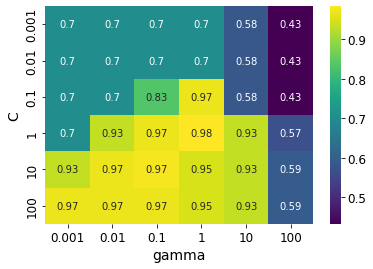

In [27]:
import seaborn as sns

scores = np.array(scores_df.mean_test_score).reshape(6, 6)

sns.heatmap(scores, xticklabels=param_grid['gamma'],
            yticklabels=param_grid['C'], cmap="viridis",
            annot=True)
plt.xlabel('gamma')
plt.ylabel('C')
plt.show()

히트맵의 각 포인트는 특정 매개변수 설정에 대한 교차 검증 실행을 나타낸다. 교차 검증의 정확도가 높으면 밝은 색으로, 낮으면 어두운 색으로 나타냈다. 그래프를 보면 SVC가 매개변수 설정에 매우 민감함을 알 수 있다. 많은 매개변수 설정에서 50% 부근의 낮은 정확도를 내고 있지만 어떤 설정에서는 98% 이상을 만들었다. 이 그래프에서 몇 가지 정보를 얻을 수 있다. 먼저 높은 성능을 얻으려면 매개변수 조정이 매우 중요하다는 점이다. 두 매개변수(C와 gamma)가 매우 중요하며 어떻게 조정하는지에 따라 정확도가 50%에서 98%까지 차이가 난다. 또 선택한 매개변수 그리드의 범위에서 결괏값이 크게 변하고 있다. 즉, 각 매개변수의 최적값이 그래프 끝에 놓이지 않도록 매개변수의 범위가 충분히 넓다는 점이 중요하다.

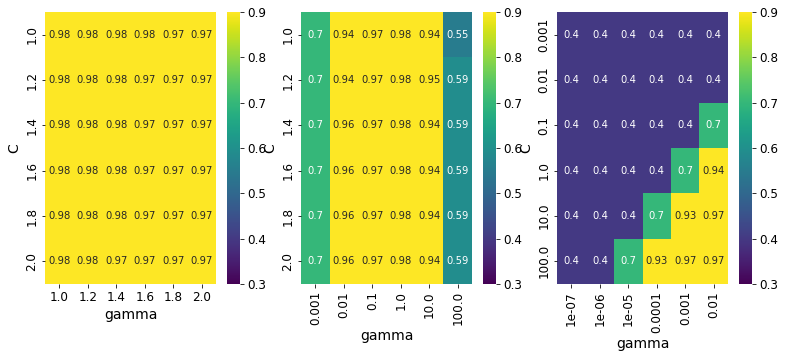

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(13, 5))

param_grid_linear = {'C': np.linspace(1, 2, 6),
                     'gamma': np.linspace(1, 2, 6)}

param_grid_one_log = {'C': np.linspace(1, 2, 6),
                      'gamma': np.logspace(-3, 2, 6)}

param_grid_range = {'C': np.logspace(-3, 2, 6),
                    'gamma': np.logspace(-7, -2, 6)}

for param_grid, ax in zip([param_grid_linear, param_grid_one_log,
                            param_grid_range], axes):
    grid_search = GridSearchCV(SVC(), param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    scores = grid_search.cv_results_['mean_test_score'].reshape(6, 6)
    
    scores_image = sns.heatmap(scores, xticklabels=param_grid['gamma'],
                               yticklabels=param_grid['C'], ax=ax, cmap="viridis",
                               vmin=0.3, vmax=0.9, annot=True)
    ax.set_xlabel('gamma')
    ax.set_ylabel('C')
    
plt.show()

첫 번째 그래프는 점수 변화가 전혀 없어서 전체 매개변수 그리드가 같은 색이다. 이런 결과는 매개변수 C와 gamma의 스케일과 범위가 부적절할 때 발생한다. 그러나 매개변수 설정이 바뀌어도 정확도에 아무런 변화가 없다면, 그 매개변수가 전혀 중요하지 않은 것일 수도 있다. 처음에는 매우 극단적인 값을 적용해보고, 매개변수를 바꿔가며 정확도가 변하는지 살펴보는 것이 좋다.

두 번째 그래프는 세로 띠 형태를 보인다. 이는 gamma 매개변수만 정확도에 영향을 준다는 뜻이다. 즉 gamma 매개변수는 적절한 범위를 탐색하고 있지만, C 매개변수는 그렇지 못하든지, 아니면 중요한 매개변수가 아닐 수도 있다.

세 번째 그래프는 C와 gamma 둘 모두에 따라 값이 변했다. 하지만 그래프의 왼쪽 위 영역에서는 아무런 변화가 없다. 아마도 다음 번 검색 땐 매개변수 그리드에서 매우 작은 단위는 제외될 것이다. 최적치가 그래프의 경계에 있으니 이 경계 너머에 더 나은 값이 있다고 생각할 수 있다. 그러니 이 영역이 포함되도록 매개변수 검색 범위를 바꿔줘야 한다.

교차 검증 점수를 토대로 매개변수 그리드를 튜닝하는 것은 아주 안전한 방법이며, 매개변수들의 중요도를 확인하는 데도 좋다.

## 비대칭 매개변수 그리드 탐색

어떤 경우에는 모든 매개변수의 조합에 대해 GridSearchCV를 수행하는 것이 좋은 생각이 아닐 수 있다. 예를 들어 SVC는 kernel 매개변수를 가지고 있는데 어떤 커널을 사용하는지에 따라 관련 있는 매개변수들이 결정된다. kernel='linear'이면 선형 모델이고 C 매개변수만 사용한다. kernel='rbf'이면 C와 gamma를 모두 사용한다(하지만 degree 같은 다른 매개변수는 사용하지 않는다). 이런 경우에 C, gamma, kernel 매개변수의 모든 조합을 조사하는 것은 맞지 않다. kernel='linear'이면 gamma를 사용하지 않으므로 gamma의 값에 대해 조사하는 것은 시간 낭비다. 이런 조건부 매개변수 조합을 적용하려면 GridSearchCV에 전달할 param_grid를 딕셔너리의 리스트를 만들어주면 된다. 리스트에 있는 각 딕셔너리는 독립적인 딕셔너리로 적용된다. kernel을 포함한 매개변수 그리드의 예는 다음과 같다.

In [29]:
param_grid = [{'kernel': ['rbf'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100],
               'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'kernel': ['linear'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100]}]
print("그리드 목록:\n", param_grid)

그리드 목록:
 [{'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}, {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]


첫 번째 그리드에서 kernel 매개변수는 rbf로 고정되고(kernel 항목의 리스트 길이가 1이다), C와 gamma 두 매개변수는 바뀐다. 두 번째 그리드에서 kernel 매개변수는 항상 linear로 고정되고 C만 바뀐다. 이제 이 매개변수 그리드를 적용해보겠다.

In [30]:
grid_search = GridSearchCV(SVC(), param_grid, cv=5, return_train_score=True)
grid_search.fit(X_train, y_train)
print("최적 파라미터:", grid_search.best_params_)
print("최고 교차 검증 점수: {:.2f}".format(grid_search.best_score_))

최적 파라미터: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
최고 교차 검증 점수: 0.98


cv_results_ 속성을 다시 살펴보겠다. 예상대로 kernel이 linear일 땐 C만 변경되었다.

In [31]:
results = pd.DataFrame(grid_search.cv_results_)
display(results.T)

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
mean_fit_time,0.001423,0.001605,0.001001,0.001502,0.001201,0.001601,0.001403,0.001203,0.001504,0.001903,...,0.000802,0.001303,0.001205,0.002305,0.001697,0.000998,0.000803,0.000801,0.000502,0.000801
std_fit_time,0.0004,0.000491,0.000004,0.000448,0.000399,0.000489,0.00049,0.000405,0.000451,0.000198,...,0.000401,0.0004,0.000402,0.000402,0.000394,0.000004,0.000402,0.000401,0.000448,0.000401
mean_score_time,0.001099,0.000999,0.0002,0.001016,0.000102,0.000701,0.0004,0.000903,0.001,0.000602,...,0.000401,0.000403,0.0009,0.001099,0.0002,0.0009,0.000599,0.000302,0.000602,0.000302
std_score_time,0.000154,0.000001,0.0004,0.000029,0.000203,0.000398,0.00049,0.000492,0.000633,0.000491,...,0.000492,0.000494,0.000196,0.000201,0.0004,0.000491,0.000489,0.000605,0.000492,0.000401
param_C,0.001,0.001,0.001,0.001,0.001,0.001,0.01,0.01,0.01,0.01,...,100,100,100,100,0.001,0.01,0.1,1,10,100
param_gamma,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,...,0.1,1,10,100,NaN,NaN,NaN,NaN,NaN,NaN
param_kernel,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,...,rbf,rbf,rbf,rbf,linear,linear,linear,linear,linear,linear
params,"{'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 10, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}",...,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 10, 'kernel': 'rbf'}","{'C': 100, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.001, 'kernel': 'linear'}","{'C': 0.01, 'kernel': 'linear'}","{'C': 0.1, 'kernel': 'linear'}","{'C': 1, 'kernel': 'linear'}","{'C': 10, 'kernel': 'linear'}","{'C': 100, 'kernel': 'linear'}"
split0_test_score,0.666667,0.666667,0.666667,0.666667,0.541667,0.416667,0.666667,0.666667,0.666667,0.666667,...,0.916667,0.875,0.958333,0.583333,0.666667,0.708333,0.916667,0.916667,0.916667,0.958333
split1_test_score,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,...,1.0,0.958333,0.875,0.5,0.333333,0.875,1.0,1.0,1.0,1.0


## 중첩 교차 검증을 사용한 알고리즘 선택

앞선 예에서 데이터를 한 번에 훈련, 검증, 테스트 세트로 나눈 방식에서, 훈련 세트와 테스트 세트로 나눈 다음 훈련 세트로 교차 검증을 수행하는 방식으로 바꿨다. 하지만 GridSearchCV를 사용할 때 여전히 데이터를 훈련 세트와 테스트 세트로 한 번만 나누기 때문에, 결과가 불안정하고 테스트 데이터의 분할에 크게 의존한다. 원본 데이터를 훈련 세트와 테스트 세트로 한 번만 나누는 방식 대신 더 나아가 교차 검증 분할 방식을 사용할 수 있다. 이를 <b>중첩 교차 검증</b><sup>nested cross-validation</sup>이라고 한다. 이는 여러 종류의 머신 러닝 알고리즘을 비교할 때 권장된다. 오차 예측에 대한 편향을 연구하는 중에 바르마<sup>Varma</sup>와 사이몬<sup>Simon</sup>은 중첩된 교차 검증을 사용했을 때 테스트 세트에 대한 추정 오차는 거의 편향되지 않는다는 결론을 얻었다.<sup><a id="a05" href="#p05">[5]</a></sup>

중첩 교차 검증에서는 바깥쪽 루프에서 데이터를 훈련 세트와 테스트 세트로 나눈다. 그리고 각 훈련 세트에 대해 그리드 서치를 실행한다(아마도 바깥쪽 루프에서 분할된 훈련 세트마다 최적의 매개변수가 다를 것이다). 그런 다음 바깥쪽에서 분할된 테스트 세트의 점수를 최적의 매개변수 설정을 사용해 각각 측정한다.  [그림 3]은 바깥 루프에서 다섯 개의 폴드를 사용하고 안쪽 루프에 두 개의 폴드를 사용하는 중첩 교차 검증의 개념을 보여 준다. 이런 방식은 계산 성능이 중요한 대용량 데이터셋에서 유용하다. 중첩 교차 검증의 폴드 개수를 고려하여 5 x 2 교차 검증이라고 한다.<sup><a id="a06" href="#p06">[6]</a></sup>

<b>그림 3</b> 중첩 교차 검증
<div style="text-align:center;">
    <img src="./images/model_selection/중첩 교차 검증.jpg">
</div>

이 방법은 모델이나 매개변수 설정이 아닌 테스트 점수의 목록을 만들어준다. 이 점수들은 그리드 서치를 통해 찾은 최적의 매개변수가 모델을 얼마나 잘 일반화시키는지 알려준다. 새로운 데이터에 적용할 모델을 만드는 것이 아니니, 중첩 교차 검증은 미래의 데이터에 적용하기 위한 예측 모델을 찾는 데는 거의 사용되지 않는다. 그러나 특정 데이터셋에서 주어진 모델이 얼마나 잘 일반화되는지 평가하는 데 유용한 방법이다.

사이킷런에서는 다음과 같이 중첩 교차 검증을 직관적으로 구현할 수 있다. GridSearchCV의 객체를 모델로 삼아 <code>cross_val_score()</code> 함수를 호출하면 된다.

In [33]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
scores = cross_val_score(GridSearchCV(SVC(), param_grid, cv=2),
                         data, label, cv=5)
print("교차 검증 점수: ", scores)
print("교차 검증 평균 점수: ", scores.mean())

교차 검증 점수:  [0.96666667 1.         0.9        0.96666667 1.        ]
교차 검증 평균 점수:  0.9666666666666668


중첩 교차 검증의 결과를 요약하면 "SVC는 iris 데이터셋에서 평균 교차 검증 정확도가 96%다"라고 할 수 있으며, 그 이상도 이하도 아니다.

여기에서 안쪽 루프는 계층형 2-겹 교차 검증, 바깥쪽 루프는 계층형 5-겹 교차 검증을 사용했다. param_grid의 매개변수 조합은 36개다. 이때 만들어지는 모델은 총 36 x 5 x 2 = 360개나 되므로 중첩 교차 검증은 매우 비싼 방법이다. 여기서 안쪽 루프와 바깥쪽 루프에 같은 교차 검증 분할기를 사용했다. 하지만 꼭 이렇게 해야 하는 것은 아니므로 안쪽과 바깥쪽 루프에 각기 다른 교차 검증 전략을 조합해 사용할 수 있다. 이 한줄짜리 코드에서 어떤 작업이 일어나는지 이해하기가 좀 어렵지만, 아래 예처럼 for 문을 사용하여 간단하게 구현해보면 이해하는 데 도움이 된다.

In [37]:
def nested_cv(X, y, inner_cv, outer_cv, Classifier, parameter_grid):
    outer_scores = []
    # outer_cv이 분할을 순회하는 for 루프
    # (split 메소드는 훈련과 테스트 세트에 해당하는 인덱스를 반환한다.)
    for training_samples, test_samples in outer_cv.split(X, y):
        # 최적의 매개변수를 찾는다.
        best_params = {}
        best_score = -np.inf
        # 매개변수 그리드를 순회한다
        for parameters in parameter_grid:
            # 안쪽 교차 검증의 점수를 기록한다.
            cv_scores = []
            # inner_cv의 분할을 순회하는 for 루프
            for inner_train, inner_test in inner_cv.split(
                    X[training_samples], y[training_samples]):
                # 훈련 데이터와 주어진 매개변수로 분류기를 만든다.
                clf = Classifier(**parameters)
                clf.fit(X[inner_train], y[inner_train])
                # 검증 세트로 평가한다.
                score = clf.score(X[inner_test], y[inner_test])
                cv_scores.append(score)
            # 안쪽 교차 검증의 평균 점수를 계산한다.
            mean_score = np.mean(cv_scores)
            if mean_score > best_score:
                # 점수가 더 높으면 매개변수와 함께 기록한다.
                best_score = mean_score
                best_params = parameters
        # 바깥쪽 훈련 데이터 전체를 사용해 분류기를 만든다.
        clf = Classifier(**parameters)
        clf.fit(X[training_samples], y[training_samples])
        # 테스트 세트를 사용해 평가한다.
        outer_scores.append(clf.score(X[test_samples], y[test_samples]))
    return np.array(outer_scores)

이 함수를 iris 데이터셋에 적용해보겠다.

In [42]:
from sklearn.model_selection import ParameterGrid, StratifiedKFold
scores = nested_cv(iris.data, iris.target, StratifiedKFold(5),
                   StratifiedKFold(5), SVC, ParameterGrid(param_grid))
print("교차 검증 점수:", scores)

교차 검증 점수: [0.66666667 0.56666667 0.56666667 0.66666667 0.56666667]


## 교차 검증과 그리드 서치 병령화

그리드 서치는 데이터 용량이 크고 매개변수 수도 많을 때는 상당한 연산 부하를 일으키지만, 다행히 쉽게 병렬화할 수 있다. 하나의 교차 검증 분할에서 특정 매개변수 설정을 사용해 모델을 만드는 일은 다른 매개변수 설정이나 모델과 전혀 상관없이 진행할 수 있기 때문이다. 그러므로 그리드 서치와 교차 검증은 여러 CPU 코어 또는 클러스터에 병렬화하기 좋다. GridSearchCV와 cross_val_score에서 n_jobs 매개변수에 사용할 CPU 코어 수를 지정할 수 있다. n_jobs=-1이면 가능한 모든 코어를 사용한다.

아직 충분히 테스트되지는 않았지만 사이킷런 0.20.0부터는 모델과 GridSearchCV에 모두 n_jobs 매개변수를 지정할 수 있다. 데이터셋과 모델이 매우 클 때는 여러 코어를 사용하면 너무 많은 메모리를 차지한다. 그래서 대규모 모델을 병렬로 만들 땐 메모리 사용 현황을 모니터링하는 것이 좋다.

분산 컴퓨팅 패키지인 Dask를 사용하여 클러스터의 여러 머신에서 그리드 서치와 교차 검증을 병렬화할 수도 있다.

# 학습 곡선과 검증 곡선을 사용한 알고리즘 디버깅

학습 알고리즘의 성능 향상에 도움이 되는 간단하지만 아주 강력한 두 개의 분석 도구를 살펴보겠다. 학습 곡선과 검증 곡선이다. 다음 절에서 학습 곡선을 사용하여 학습 알고리즘이 문제에 과대적합(높은 분산)되는지 또는 과소적합(높은 편향)되는지 분석하는 방법을 설명한다. 또 학습 알고리즘의 보편적인 문제를 다루는 데 도움이 되는 검증 곡선에 대해 알아보겠다.

## 학습 곡선으로 편향과 분산 문제 분석

주어진 훈련 데이터셋에 비해 모델이 너무 복잡하면, 즉 모델의 자유도나 모델 파라미터가 너무 많으면 모델이 훈련 데이터에 과대적합되고 처음 본 데이터에 잘 일반화되지 못하는 경향이 있다. 보통 훈련 샘플을 더 모으면 과대적합을 줄이는 데 도움이 된다. 실전에서는 데이터를 더 모으는 것이 매우 비싸거나 그냥 불가능할 때도 많다. 모델의 훈련 정확도와 검증 정확도를 훈련 세트의 크기 함수로 그래프를 그려 보면 모델에 높은 분산의 문제가 있는지 높은 편향의 문제가 있는지 쉽게 감지할 수 있다. 더 많은 데이터를 모으는 것이 문제를 해결할 수 있을지 판단이 가능하다. 사이킷런으로 학습 곡선을 그리는 방법을 보기 전에 [그림 4]에서 두 종류의 문제에 대해 논의해 보자.

<b>그림 4</b> 편향-분산 트레이드오프
<div style="text-align:center;">
    <img src="./images/model_selection/편향-분산 트레이드오프.png">
</div>

왼쪽 위 그래프는 편향이 높은 모델을 보여 준다. 이 모델은 훈련 정확도와 교차 검증 정확도가 모두 낮다. 즉 두 곡선이 수평한 구간을 만들고 꽤 낮은 정확도에서 매우 가까이 근접해 있다. 이는 훈련 데이터에 과소적합되었다는 것을 나타낸다. 이 문제를 해결하는 일반적인 방법은 모델의 파라미터 개수를 늘리는 것이다. 예를 들어 추가적인 특성을 수집하거나 만든다. 또는 SVM이나 로지스틱 회귀 분류기에서 규제 강도를 줄인다.

오른쪽 위 그래프는 분산이 높은 모델을 보여 준다. 훈련 정확도와 교차 검증 정확도 사이에 큰 차이가 있다는 것을 나타낸다. 과대적합 문데를 해결하려면 더 많은 훈련 데이터를 모으거나 모델 복잡도를 낮추거나 규제를 증가시킬 수 있다. 규제가 없는 모델에서는 특성 선택이나 특성 추출을 통해 특성 개수를 줄여 과대적합을 감소할 수 있다. 더 많은 훈련 데이터를 수집하는 것이 보통 과대적합의 가능성을 줄이지만 항상 도움이 되는 것은 아니다. 예를 들어 훈련 데이터에 잡음이 아주 많거나 모델이 이미 거의 최적화가 된 경우다.

다음 절에서 검증 곡선을 사용하여 이런 문제들을 다루는 법을 알아보겠다. 먼저 사이킷런의 학습 곡선 함수를 사용하여 모델을 평가해 보자.

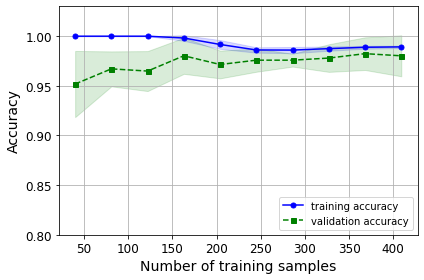

In [50]:
from sklearn.model_selection import learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(solver='liblinear', 
                                           penalty='l2',
                                           random_state=1))

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_lr,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()

<code>learning_curve()</code> 함수의 train_sizes 매개변수를 통해 학습 곡선을 생성하는 데 사용할 훈련 샘플의 개수나 비율을 지정할 수 있다. 여기서는 <code>train_sizes=np.linspace(0.1, 1.0, 10)</code>으로 지정해서 일정한 간격으로 훈련 세트의 비율 열 개를 설정했다. 기본적으로 <code>learning_curve()</code> 함수는 계층별 k-겹 교차 검증을 사용하여 분류기의 교차 검증 정확도를 계산한다. cv 매개변수를 통해 k 값을 10으로 지정했기 때문에 계층별 10-겹 교차 검증을 사용한다. 반환된 훈련과 테스트 교차 검증 점수로부터 훈련 세트 크기별로 평균 정확도를 계산하여 맷플롯립의 <code>plot()</code> 함수를 사용해서 그래프를 그린다. <code>fill_between()</code> 함수를 사용하여 그래프에 평균 정확도의 표준 편차를 그려서 추정 분산을 나타냈다.

앞의 학습 곡선 그래프에서 볼 수 있듯이 모델 훈련에 250개 샘플 이상을 사용할 때 훈련과 검증 세트에서 잘 작동한다. 훈련 세트가 250개의 샘플보다 줄어들면 훈련 정확도가 증가하면서 훈련 정확도와 검증 정확도 사이의 차이는 넓어진다. 이는 과대적합이 증가한다는 증거다.

참고로, 모델이 훈련 데이터에 과소적합되어 있다면 훈련 샘플을 더 추가해도 효과가 없다. 더 복잡한 모델을 사용하거나 더 나은 특성을 선택해야 한다. 추가로 과대적합 모델을 개선하는 한 가지 방법은 검증 오차가 훈련 오차에 근접할 때까지 더 많은 훈련 데이터를 추가하는 것이다.

<div style="border:1px solid; padding:10px;">
    <div style="text-align: center"><strong>편향/분산 트레이드오프</strong></div><br>
    통계학과 머신러닝에서 나온 중요한 이론 하나는 모델의 일반화 오차는 세 가지 다른 종류의 오차의 합으로 표현할 수 있다는 사실이다. 즉 다음과 같은 식을 따른다.
    $$
    \mathrm{E}[(y - \hat{f}(x))^2] = \mathrm{Bias}[\hat{f}(x)]^2 + \mathrm{Var}[\hat{f}(x)] + \sigma^2
    $$
    여기서 $y$는 실제 관계함수, $\hat{f}(x)$는 학습을 통해 실제 관계함수를 최대한 잘 근사한 근사함수, $\sigma$는 줄일 수 없는 오차를 뜻한다.
    <ul>
        <li><b>편향</b><br>
            일반화 오차 중에서 편향은 잘못된 가정으로 인한 것이다. 예를 들어 데이터가 실제로는 2차인데 선형으로 가정하는 경우다. 편향이 큰 모델은 훈련 데이터에 과소적합되기 쉽다.
        $$
        \mathrm{Bias}[\hat{f}(x)] = \mathrm{E}[\hat{f}(x) - f(x)]
        $$</li>
        <li><b>분산</b><br>
            분산<sup>variance</sup>은 훈련 데이터에 있는 작은 변동에 모델이 과도하게 민감하기 때문에 나타난다. 자유도가 높은 모델(예를 들면 고차 다항 회귀 모델)이 높은 분산을 가지기 쉬워 훈련 데이터에 과대적합되는 경향이 있다. $\hat{f}(x)$가 그 평균 근처에서 얼마만큼의 폭으로 변동하느냐를 나타낸다.
        $$
        \mathrm{Var}[\hat{f}(x)] = \mathrm{E}[(\hat{f}(x) - \mathrm{E}[\hat{f}(x)])^2]
        $$</li>
        <li><b>줄일 수 없는 오차</b><br>
            줄일 수 없는 오차<sup>irreducible error</sup>는 데이터 자체에 있는 잡음 때문에 발생한다. 이 오차를 줄일 수 있는 유일한 방법은 데이터에서 잡음을 제거하는 것이다(예를 들어 고장 난 센서 같은 데이터 소스를 고치거나 이상치를 감지해 제거한다).</li>
    </ul>
<br>
    <b>유도</b><br>
        제곱 오류를 편향-분산 분해하는 과정의 유도는 다음과 같이 할 수 있다. 편의를 위해 $f = f(x)$ 그리고 $\hat{f} = \hat{f}(x)$로 두겠다. 우선 확률 변수 $\mathrm{X}$에 대해<br>
    $\begin{align*}
E[X^2] &= E[X^2] - E[2XE[X]] + E[E[X]^2] + E[2XE[X]] - E[E[X]^2]\\
 &= E[X^2 - 2XE[X] + E[X]^2] + 2E[X]^2 - E[X]^2\\
 &= E[(X - E[X])^2] + E[X]^2\\
 &= \text{Var}[X] + E[X]^2
\end{align*}$
    <br>이고, $f$의 값들은 결정되어 있으므로<br>
    $0 = \text{Var}[f] = E[(f - E[f])^2]\Rightarrow f - E[f] = 0 \Rightarrow E[f] = f$
    <br>가 성립한다.<br>
    주어진 조건 $y = f + \epsilon$과 $E[\epsilon] = 0$으로부터 $E[y] = E[f + \epsilon] = E[f] = f$가 성립한다($\because \epsilon\text{은 평균이 0이고, 분산이}\,\sigma^2\text{인 정규분포}$).
    <br>그리고 $\text{Var}[\epsilon] = \sigma^2$ 이므로,<br>
    $\text{Var}[y] = E[(y - E[y])^2] = E[(y - f)^2] = E[(f + \epsilon - f)^2] = E[\epsilon^2] = \text{Var}[\epsilon] + E[\epsilon]^2 = \sigma^2$
    <br>$\epsilon$과 $\hat{f}$는 서로 독립적이므로,<br>
    $\begin{align*}
 E[(y - \hat{f})^2]&= E[y^2 + \hat{f}^2 - 2y\hat{f}]\\
 &= E[y^2] + E[\hat{f}^2] - E[2y\hat{f}] \\
 &= \text{Var}[y] + E[y]^2 + \text{Var}[\hat{f}] + E[\hat{f}]^2 - 2fE[\hat{f}]\\
 &= \text{Var}[y] + \text{Var}[\hat{f}] + (f - E[\hat{f}])^2\\
 &= \sigma^2 + \text{Var}[\hat{f}] + \text{Bias}[\hat{f}]^2
\end{align*}$
    <br>가 성립한다.<br>
        <br>따라서, 모델의 복잡도가 커지면 통상적으로 분산이 늘어나고 편향은 줄어든다. 반대로 모델의 복잡도가 줄어들면 편향이 커지고 분산이 작아진다. 그래서 트레이드오프라고 부른다.
</div>

## 검증 곡선으로 과대적합과 과소적합 조사

검증 곡선은 과대적합과 과소적합 문제를 해결하여 모델 성능을 높일 수 있는 유용한 도구다. 검증 곡선은 학습 곡선과 관련이 있지만 샘플 크기의 함수로 훈련 정확도와 테스트 정확도를 그리는 대신 모델 파라미터 값의 함수로 그린다. 예를 들어 로지스틱 회귀에 있는 규제 매개변수 C다. 사이킷런으로 검증 곡선을 만드는 방법을 알아보자.

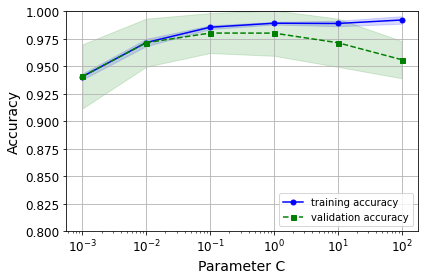

In [51]:
from sklearn.model_selection import validation_curve

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
                estimator=pipe_lr,
                X=X_train,
                y=y_train,
                param_name='logisticregression__C',
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(param_range,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.00])
plt.tight_layout()
plt.show()

위 그래프는 매개변수 C에 대한 검증 곡선 그래프다.

<code>learning_curve()</code> 함수와 비슷하게 <code>validation_curve()</code> 함수는 기본적으로 계층별 k-겹 교차 검증을 사용하여 모델의 성능을 추정한다. <code>validation_curve()</code> 함수 안에서 평가하기 원하는 매개변수를 지정한다. 이 경우에는 LogisticRegression 분류기의 규제 매개변수인 C다. 사이킷런의 파이프라인 안에 있는 LogisticRegression 객체의 매개변수를 지정하려면 'logisticregression__C'처럼 쓴다. param_range 매개변수에는 값 범위를 지정한다. 이전 절의 학습 곡선 예와 비슷하게 평균 훈련 정확도와 교차 검증 정확도를 그리고 이에 상응하는 표준 편차를 나타냈다.

C 값이 바뀜에 따라 정확도 차이가 미묘하지만 규제 강도를 높이면(C값을 줄이면) 모델이 데이터에 조금 과소적합되는 것을 볼 수 있다. 규제 강도가 낮아지는 큰 C 값에서는 모델이 데이터에 조금 과대적합되는 경향을 보인다. 이 경우에 적절한 C 값은 0.01과 0.1 사이다.

# 그림을 위한 코드

In [46]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data', header=None)

# UCI 머신 러닝 저장소에서 유방암 데이터셋을 다운로드할 수 없을 때
# 다음 주석을 해제하고 로컬 경로에서 데이터셋을 적재하세요.

# df = pd.read_csv('wdbc.data', header=None)

df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [47]:
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [48]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y,
                     test_size=0.20,
                     stratify=y,
                     random_state=1)

In [49]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(solver='liblinear', random_state=1))

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('테스트 정확도: %.3f' % pipe_lr.score(X_test, y_test))

테스트 정확도: 0.956


# 미주

<b id="p01">1</b> 교차 검증 반복에서 테스트에 사용되는 폴드를 종종 검증 폴드라고도 한다. [↩](#a01)

<b id="p02">2</b> A Study of Cross-Validation and Bootstrap for Accuracy Estimation and Model Selection, Kohavi, Ron, International Joint Conference on Artificial Intelligence (IJCAI), 14(12):1137-43, 1995 [↩](#a02)

<b id="p03">3</b> 사이킷런의 sklearn.model_selection 패키지 밑에 LOOCV 방법을 구현한 LeaveOneOut 클래스가 있다. [↩](#a03)

<b id="p04">4</b> A Study of Corss-Validation and Bootstrap for Accuracy Estimation and Model Selection, International Joint Conference on Artificial Intelligence (IJCAI), 14 (12): 1137-43, 1995 [↩](#a04)

<b id="p05">5</b> Bias in Error When Using Cross-validation for Model Selection, MBC Bioinformatics, S. Varma and R. Simon, 7(1): 91, 2006 [↩](#a05)

<b id="p06">6</b> 교차 검증 횟수가 늘어나면 반복마다 전처리 과정을 반복하는 것이 낭비다. 사이킷런 0.19 버전에서 전처리 결과를 캐싱하여 실행 속도를 높일 수 있도록 Pipeline 클래스와 make_pipeline 함수에 memory 매개변수가 추가되었다. memory 매개변수에 캐싱에 사용할 디렉터리 경로를 지정할 수 있다. [↩](#a06)